In [1]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings
import os
#in practice do not supress these warnings, they carry important information about the status of your model
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [5]:
def prepare_data(ticker, start_date, end_date):
    # Download the data
    df = yf.Ticker(ticker)
    df = df.history(start=start_date, end=end_date)
    df.reset_index(inplace=True)

    # Convert the datetime to a date only object
    df["Date"] = df["Date"].dt.date
    df["Date"] = pd.to_datetime(df["Date"])

    # Load and merge macroeconomic data
    macro_econ = pd.read_csv(os.path.join("datasets", 'macroeconomics_data.csv'))
    macro_econ["Date"] = pd.to_datetime(macro_econ["Date"])
    df = df.merge(macro_econ, on="Date", how="left")

    # Drop unnecessary columns
    df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

    # Create target variable
    df["tomorrow"] = df["Close"].shift(-1)
    df["target"] = (df["tomorrow"] > df["Close"]).astype(int)

    # Lower case all the column names
    df.columns = [col.lower() for col in df.columns]

    # Set 'date' as the index
    df.set_index('date', inplace=True)

    return df

In [6]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds > 0.5] = 1
    preds[preds <= 0.5] = 0
    preds = pd.Series(preds, index=test.index, name='predicted')
    combined = pd.concat([test['target'], preds], axis=1)
    cm = confusion_matrix(combined['target'], combined['predicted'])
    TN, FP, FN, TP = cm.ravel()
    return combined, TN, FP, FN, TP

def backtest(data, model, predictors, start=1500, step=125):
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[:i].copy()
        test = data.iloc[i:i+step].copy()
        predictions, TN, FP, FN, TP  = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions), TN, FP, FN, TP

In [7]:
# Function to perform simplified feature engineering
def generate_features(data):
    data = data.copy()
    
    # Generating macro features
    
    # Price-based Features
    data['10yr_treasury_bill_ma'] = data['10-year treasury'].rolling(window=20).mean()
    data['inflation_rate_change'] = data['cpi'].pct_change()
    data['unemployment_rate_rolling'] = data['unemployment rate'].rolling(window=14).mean()

    # Lagged Features
    data['lag_10yr_treasury_bill_1'] = data['10-year treasury'].shift(1)
    data['lag_inflation_rate_1'] = data['cpi'].shift(1)
    data['lag_unemployment_rate_1'] = data['unemployment rate'].shift(1)

    # Other Macro Features (add more as needed)
    data['10yr_treasury_bill_diff'] = data['10-year treasury'].diff()
    data['inflation_rate_squared'] = data['cpi'] ** 2
    
    
    # Price-based Features
    data['ma20'] = data['close'].rolling(window=20).mean()
    data['ma50'] = data['close'].rolling(window=50).mean()
    data['rate_of_change'] = data['close'].pct_change()
    data['volatility'] = data['close'].pct_change().rolling(window=20).std()

    # Volume-based Features
    data['avg_volume'] = data['volume'].rolling(window=20).mean()
    data['relative_volume'] = data['volume'] / data['avg_volume']

    # Technical Indicators
    data['rsi'] = 100 - (100 / (1 + data['close'].rolling(window=14).apply(lambda x: np.where(x.diff() > 0, x.diff(), 0).sum() / np.where(x.diff() < 0, -x.diff(), 0).sum())))
    data['macd_line'] = data['close'].rolling(window=12).mean() - data['close'].rolling(window=26).mean()
    data['stochastic_oscillator'] = 100 * (data['close'] - data['close'].rolling(window=14).min()) / (data['close'].rolling(window=14).max() - data['close'].rolling(window=14).min())

    # Price Rate of Change
    data['price_rate_of_change_5'] = data['close'].pct_change(5)
    data['price_rate_of_change_20'] = data['close'].pct_change(20)

    # Lagged Features
    data['lag_close_1'] = data['close'].shift(1)
    data['lag_volume_1'] = data['volume'].shift(1)

    # Day-of-Week Features
    data['day_of_week'] = data.index.dayofweek

    # Moving Averages Cross-Over
    data['ma_cross_over'] = np.where(data['ma20'] > data['ma50'], 1, 0)


    horizons = [2, 5, 60, 250, 1000]

    for horizon in horizons:
        rolling_averages = data['close'].rolling(horizon).mean()

        ratio_column = f"close_ratio_{horizon}"
        data[ratio_column] = data['close'] / rolling_averages

        trend_column = f"trend_{horizon}"
        data[trend_column] = data.target.shift(1).rolling(horizon).sum()

    return data.dropna()

In [10]:
df = prepare_data("AAPL", "2010-01-01", "2023-10-1")
df.loc["2023.1.1":].shape[0]

187

In [12]:
df.loc["2014.1.1":"2023.1.1"].shape[0]

2266

In [78]:
from sklearn.ensemble import RandomForestClassifier


def run_simulation(data, amt, verbose=False, plot=True):
    curr_holding = False
    events_list = []
    init_amt = amt
    # Define your predictors and target
    predictors = new_predictors = ['10-year treasury', 'rate_of_change', 'volatility', 'avg_volume',
       'relative_volume', 'rsi', 'macd_line', 'price_rate_of_change_5',
       'price_rate_of_change_20', 'lag_close_1', 'lag_volume_1',
       'close_ratio_2', 'close_ratio_5', 'close_ratio_60', 'close_ratio_250',
       'close_ratio_1000', 'inflation_rate_change', 'lag_inflation_rate_1']
    target = 'target'  # You need to define this column in your data
  
    # Prepare the features and target for the classifier
    X = data[predictors].iloc[:-1]
    y = (data[target].shift(-1).iloc[:-1] > 0).astype(int)

    # Train the classifier
    model = RandomForestClassifier(n_estimators=100, min_samples_split=50, random_state=1)
    model.fit(X, y)

    # Backtest the model
    backtest_results = backtest(data, model,new_predictors)

    # Go through dates
    for i in range(len(data) - 1):
        # Get the prediction for the current date
        if data.index[i] in backtest_results.index:
            pred = backtest_results.loc[data.index[i], 'predicted']
        else:
            continue  # Skip this iteration and move to the next date

        # If you're currently holding the stock and the prediction is 0, sell it
        if curr_holding and pred == 0:
            sell_price = data.iloc[i]['close']
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', data.index[i], ret))
            
            if verbose:
                print('Sold at $%s'%sell_price)
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')

        # If you're not currently holding the stock and the prediction is 1, buy it
        elif (not curr_holding) and pred == 1:
            curr_holding = True
            buy_price = data.iloc[i]['close']
            events_list.append(('b', data.index[i]))
            if verbose:
                print('Bought at $%s'%buy_price)
                
    if verbose:
        print('Total Amount: $%s'%round(amt,2))
            
    if plot:
        plt.figure(figsize=(10,4))

        # Find the first and last trading events
        first_event = events_list[0][1]
        last_event = events_list[-1][1]

        # Plot only the part of the data where trading occurs
        plt.plot(data.loc[first_event:last_event, 'close'])

        y_lims = (int(data['close'].min()*.95), int(data['close'].max()*1.05))
        shaded_y_lims = int(data['close'].min()*.5), int(data['close'].max()*1.5)

        for idx, event in enumerate(events_list):
            # Comment out the line that draws the vertical dashed lines
            # plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims), 
                                event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%("nothing", round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()
        
            # Get the S&P 500 data
        sp500 = yf.Ticker('^GSPC')
        sp500 = sp500.history(start=data.index[0].date(), end=data.index[-1].date())
        sp500.reset_index(inplace=True)
        sp500["Date"] = sp500["Date"].dt.date
        sp500["Date"] = pd.to_datetime(sp500["Date"])
        sp500.set_index('Date', inplace=True)

        # Buy the S&P 500 at the first event and sell it at the last event
        sp500_buy_price = sp500.loc[events_list[0][1], 'Close']
        sp500_sell_price = sp500.loc[events_list[-1][1], 'Close']
        sp500_return = (sp500_sell_price - sp500_buy_price) / sp500_buy_price

        # Calculate the return of your strategy
        strategy_return = (amt / init_amt) - 1

        # Compare the two returns
        if strategy_return > sp500_return:
            print("Congratulations! Your strategy beat the market by {} percentage points.".format((strategy_return - sp500_return) * 100))
        else:
            print("Unfortunately, your strategy did not beat the market. The market outperformed your strategy by {} percentage points.".format((sp500_return - strategy_return) * 100))
            

    return amt, backtest_results

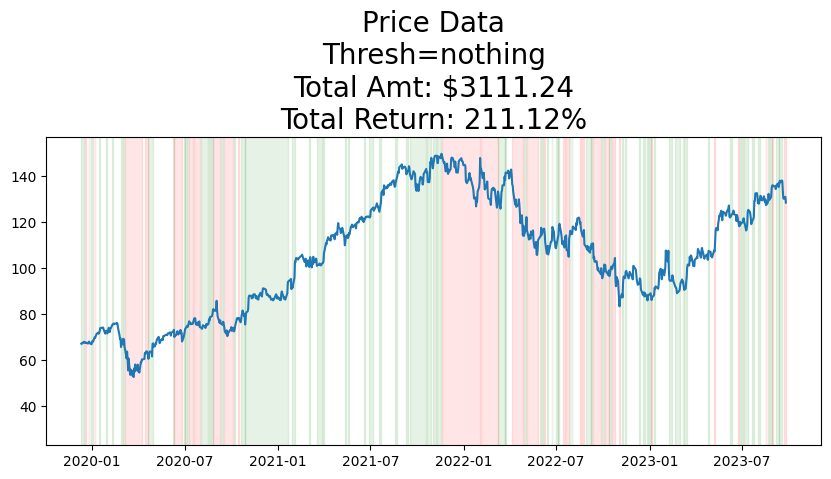

Congratulations! Your strategy beat the market by 175.09445457370828 percentage points.


In [76]:
amt, backtest_results = run_simulation(df, 1000, 
                                       verbose=False, plot=True)